<a href="https://colab.research.google.com/github/LoriRongrong/emotion_classify/blob/master/Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lorirongrong","key":"2d48425aa41b2383c425a6476c746c94"}'}

In [2]:
 ! mkdir ~/.kaggle


In [3]:
 ! cp kaggle.json ~/.kaggle/
 

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving


art-images-drawings-painting-sculpture-engraving.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip art-images-drawings-painting-sculpture-engraving.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset_updated/training_set/sculpture/i - 969.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 97.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 970.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 971.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 972.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 973.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 974.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 976.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 977.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 978.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 979.jpeg  
  inflating: dataset/dataset_updated/training_set/sculpture/i - 98.jpeg  
  inflating: dataset/dataset_updated/training_set/s

In [8]:
!mv -v musemart/dataset_updated/* musemart/

renamed 'musemart/dataset_updated/training_set' -> 'musemart/training_set'
renamed 'musemart/dataset_updated/validation_set' -> 'musemart/validation_set'


In [11]:
rm -r musemart/dataset_updated/

In [ ]:
!mv -v musemart/training_set/drawings/* musemart/training_set/
!mv -v musemart/training_set/engraving/* musemart/training_set/
!mv -v musemart/training_set/iconography/* musemart/training_set/
!mv -v musemart/training_set/painting/* musemart/training_set/
!mv -v musemart/training_set/sculpture/* musemart/training_set/

!mv -v musemart/validation_set/drawings/* musemart/validation_set/
!mv -v musemart/validation_set/engraving/* musemart/validation_set/
!mv -v musemart/validation_set/iconography/* musemart/validation_set/
!mv -v musemart/validation_set/painting/* musemart/validation_set/
!mv -v musemart/validation_set/sculpture/* musemart/validation_set/

In [ ]:
import hashlib
import sys
import os
import cv2
# clear duplicated files to reduce works 
def dup_fileremove(dirname):
    duplicate = set()
    # os.chdir(dirname)
    path=os.getcwd()
    print ("The dirname is: ", path)
    for filename in os.listdir(dirname):
        filehash = None
        filepath=os.path.join(dirname, filename)
        print("Current file path is: ", filepath)
        if os.path.isdir(filepath):
            dup_fileremove(filepath)
        elif os.path.isfile(filepath):
            im = cv2.imread(filepath)
            if im is None:
              continue
            filehash =hashlib.md5(im).hexdigest()
            if filehash not in duplicate:
                duplicate.add(filehash)
            else:
                os.remove(filepath)
                print("removed : ", filepath)

dup_fileremove('musemart/')

# Install detectron2

In [2]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# install detectron2: (colab has CUDA 10.1 + torch 1.5)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.5")
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [5]:
im = cv2.imread("./musemart/training_set/1450.jpg")
im is None
# cv2_imshow(im)

True

In [6]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


model_final_f10217.pkl: 178MB [00:02, 78.5MB/s]                           


In [7]:
mkdir segment_mask/

In [36]:
# loop through the images
# and process into segment masks
counter = 0
for filename in os.listdir('musemart/validation_set'):
  # print(filename)
  im = cv2.imread('musemart/validation_set/'+filename)
  # cv2_imshow(im)
  if im is None:
    continue
  print('musemart/validation_set/'+filename)
  outputs = predictor(im)
  # make sure it has labels and person label is in the painting
  if outputs['instances'].pred_masks.shape[0] != 0 and 0 in outputs['instances'].pred_classes:
    # print(outputs['instances'].pred_masks)
    
    mask = np.tile(outputs['instances'].pred_masks[0].cpu().numpy(), (im.shape[-1], 1, 1))
    image = np.multiply(np.moveaxis(im, -1, 0), mask)
    image = np.moveaxis(image, 0, -1)
    cv2.imwrite('segment_mask/'+ str(counter)+'.jpg', image)
    counter += 1

musemart/validation_set/1203.jpg
musemart/validation_set/images (44).jpeg
musemart/validation_set/387.jpg
musemart/validation_set/images (62).jpeg
musemart/validation_set/1954.jpg
musemart/validation_set/147.jpg
musemart/validation_set/0295.jpg
musemart/validation_set/1564.jpg
musemart/validation_set/4427_mainfoto_05.jpg
musemart/validation_set/1606.jpg
musemart/validation_set/185.jpg
musemart/validation_set/0929.jpg
musemart/validation_set/92.jpg
musemart/validation_set/1766.jpg
musemart/validation_set/0492.jpg
musemart/validation_set/3135_mainfoto_05.jpg
musemart/validation_set/420.jpg
musemart/validation_set/0121.jpg
musemart/validation_set/2247.jpg
musemart/validation_set/609.jpg
musemart/validation_set/378.jpg
musemart/validation_set/1438.jpg
musemart/validation_set/422.jpg
musemart/validation_set/608.jpg
musemart/validation_set/2093.jpg
musemart/validation_set/187.jpg
musemart/validation_set/0134.jpg
musemart/validation_set/126.jpeg
musemart/validation_set/i (21).jpeg
musemart/va

In [39]:
from google.colab import files

In [40]:
!find segment_mask/ -type f | wc -l
!zip -r segment_mask.zip segment_mask/
files.download('segment_mask.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# print(outputs["instances"].pred_classes)
# print(outputs["instances"].pred_boxes)
# print(outputs['instances'].pred_masks.shape)


tensor([0], device='cuda:0')
Boxes(tensor([[  2.8789,  43.5151, 285.0057, 358.7895]], device='cuda:0'))
torch.Size([1, 368, 290])


In [15]:
# turn the raw image to Visualizer
#  self.img = np.asarray(img_rgb).clip(0, 255).astype(np.uint8)
# self.output = VisImage(self.img, scale=scale)

In [23]:
im = cv2.imread("./musemart/training_set/0055.jpg")
outputs = predictor(im)

In [34]:
outputs['instances'].pred_classes 

tensor([ 0, 27], device='cuda:0')

In [11]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[0]

'person'

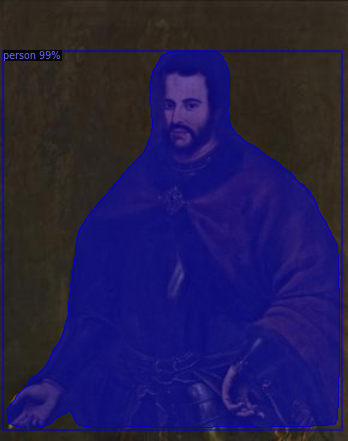

In [18]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu")) # 
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
out.get_image()

# Train on a custom dataset

# Other types of builtin models

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])